### Let's look at Message passing in Torch Geometric
First install and import the relevant packages:

In [1]:
# Import the most important things
%matplotlib inline
import math
import numpy as np
import networkx
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch_scatter import scatter_mean
import io
import PIL

from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.datasets import MD17
from torch_geometric.transforms import RadiusGraph, Compose, BaseTransform, Distance, Cartesian, RandomRotate
from torch_geometric.loader import DataLoader

from tqdm import tqdm

import torch_geometric as tg
import networkx as nx
import torchvision

import os

pl.seed_everything(42, workers=True)

Global seed set to 42


42

# **2. 2D Data: Superpixel MNIST**

Superpixel MNIST contains 2D graph representations where nodes correspond to the centers of superpixel patches (pixels grouped together according to similarity) and edges with maximum length 8. We will do graph classification on this dataset.

The message passing scheme as described in 2 does not explicitly take the geometric structure between the nodes into account; they act only on the feature vectors $f_i$ on the nodes, but not their position (that is, any structure between their position vectors $x_i$). For example, the current MPNN scheme is invariant to rotations and distance between nodes,
and hence immediately discards this information when building the node representations.

We will build node representation that respect the geometry of the manifold on which the graph lives. We will do this by injecting various geometric quantities into the edge embeddings, for example the distance between nodes, or their relative position. These choices are invariant/equivariant with respect to different groups and we will vary the input to explore how feature vectors transform under rotations. 

In [5]:
import os
import torch
import torch_geometric
from torch_geometric.transforms import RadiusGraph, Compose

batch_size = 64
radius = 8


# Regular dataloaders
transforms = [RadiusGraph(radius)]
transforms = Compose(transforms)
#transforms = None
train_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)
val_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=False)

train_loader = tg.loader.DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = tg.loader.DataLoader(val_set, batch_size=batch_size, shuffle=False)

# image mnist for visualizations
train_set_regular = torchvision.datasets.MNIST(root='./datasets', train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)
val_set_regular = torchvision.datasets.MNIST(root='./datasets', train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]), download=True)

 Here we can see what a datasample looks like (original image is plotted underneath):

Digit: 4


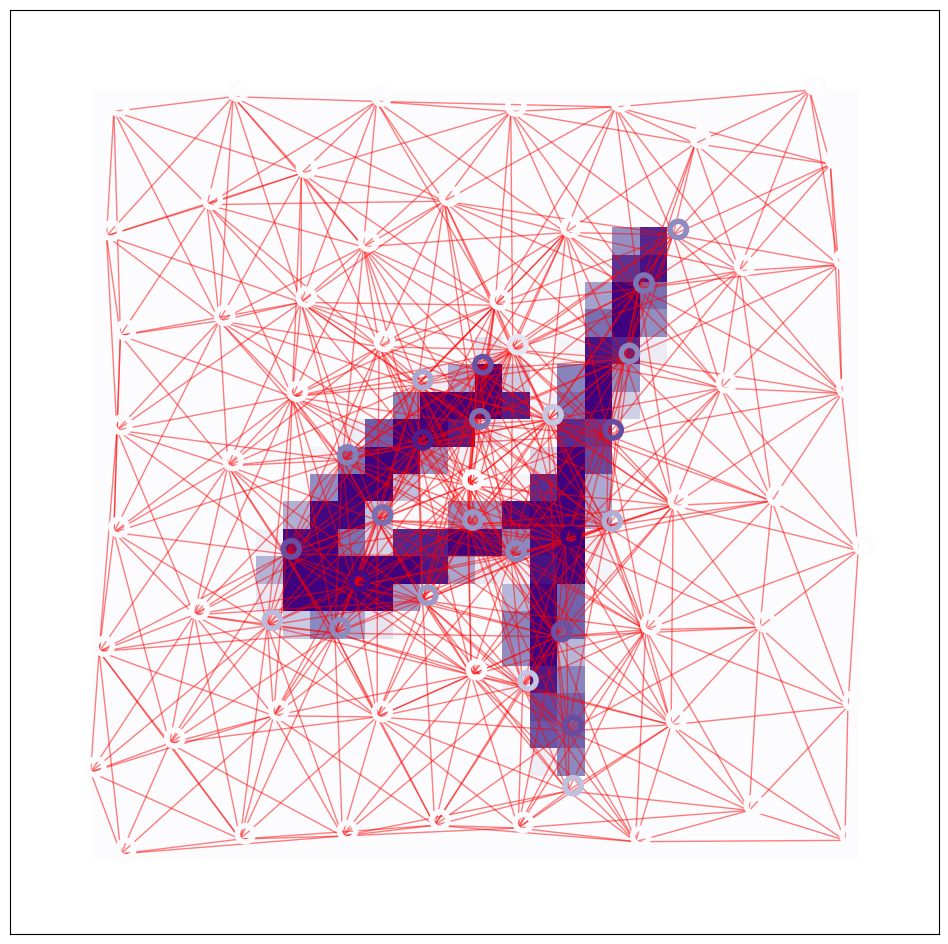

In [6]:
def visualize_sample(idx, data, regular_data):

    
    sample_graph = data[idx].clone()
    sample_graph.pos -= sample_graph.pos.min()
    sample_graph.pos = sample_graph.pos/sample_graph.pos.max() * 2 - 1
    
    
    sample_mnist = regular_data[idx][0].squeeze(0)

    pos_dict = {}
    print(f"Digit: {sample_graph.y.item()}")
    for i, p in enumerate(sample_graph.pos):
        pos_dict[i] = p.numpy() * np.array([1, -1])

    
    g = tg.utils.to_networkx(sample_graph, to_undirected=True)

    f, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(sample_mnist.numpy(), extent=[-1,1,-1,1], cmap='Purples')
    nx.draw_networkx_nodes(g, 
                           node_size=500, 
                           node_color=sample_graph.x.cpu().numpy(), 
                           node_shape=r'$\circ$', 
                           pos=pos_dict,
                           cmap='Purples')

    nx.draw_networkx_edges(g, edge_color='r', alpha=0.5, pos=pos_dict)


Recall that for batch processing of N graphs, PyG builds a single composite graph where the N graphs are disconnected. Hence, the batch element assigns to each node the index of which of the N graphs it belongs to.



In [7]:
for graphs in train_loader:
    print(f"batch_shape: {graphs.batch.shape}")
    print(f"batch_size: {graphs.batch.max() + 1}")
    # the first graph has 75 nodes: hence the batch attribute assigns the first 75 nodes to the 0th graph
    print(graphs.batch[:76])
    break

batch_shape: torch.Size([4800])
batch_size: 64
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


In the following we will train the MPNNs with three types of edge embeddings: 


*   No edge attributes
*   Euclidean distance
*   Relative distance vector

In [16]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
from torch_geometric.nn import knn_graph
from torch_cluster import knn
from torch_scatter import scatter_mean
class KMeansTransform:
    def __init__(self, k):
        self.k = k

    def __call__(self, data):
        # Perform kNN on pos
        #edge_index = knn_graph(data.pos, k=self.k, batch=None, loop=False)

        # Gather clusters based on edge indices
        clusters = knn(data.pos, data.pos, self.k)
        print('Clusters shape: ', clusters.shape)
        print('Position shape: ', data.pos.shape)
        print(clusters)
        # Compute new positions and values
        new_pos = scatter_mean(data.pos, clusters, dim=0)
        new_x = scatter_mean(data.x, clusters, dim=0)

        # Create a new graph with the updated positions and values
        new_data = Data(x=new_x, pos=new_pos)

        return new_data

In [20]:
class KMeansTransform:
    def __init__(self, k):
        self.k = k

    def __call__(self, data):
        # Perform kNN on pos
        edge_index = knn_graph(data.pos, k=self.k, batch=None, loop=False)

        # Gather clusters based on edge indices
        _, clusters = knn(data.pos, data.pos, self.k)

        # Compute the index for each cluster
        cluster_indices = clusters[1] // self.k
        print(cluster_indices)

        # Compute new positions and values
        new_pos = scatter_mean(data.pos, cluster_indices, dim=0)
        new_x = scatter_mean(data.x, cluster_indices, dim=0)

        # Create a new graph with the updated positions and values
        new_data = Data(x=new_x, pos=new_pos, edge_index=edge_index)

        return new_data


In [21]:
idx = 10
original_data = train_set[idx]
transformed_data = KMeansTransform(3)(original_data)
#visualize_sample(idx, train_set, train_set_regular)

tensor(4)


IndexError: list assignment index out of range

In [32]:
original_data

Data(x=[75, 1], edge_index=[2, 1138], y=[1], pos=[75, 2])

In [61]:
import torch
from sklearn.cluster import KMeans
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform

class KMeansClustering(BaseTransform):
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters

    def __call__(self, data):
        pos = data.pos
        x = data.x

        N = data.num_nodes
        k = N // self.num_clusters

        pos_flattened = pos.view(-1, pos.size(-1)).numpy()

        kmeans = KMeans(n_clusters=k, n_init=10)
        labels = kmeans.fit_predict(pos_flattened)

        labels = torch.from_numpy(labels)

        centroids_pos = torch.zeros(k, pos.size(-1))
        centroids_x = torch.zeros(k, x.size(-1))

        for node_idx, cluster_idx in enumerate(labels):
            centroids_pos[cluster_idx] += pos[node_idx]
            centroids_x[cluster_idx] += x[node_idx]

        for cluster_idx in range(k):
            indices = torch.nonzero(labels == cluster_idx).view(-1)
            count = indices.size(0)

            centroids_pos[cluster_idx] /= count
            centroids_x[cluster_idx] /= count

        clustered_graph = Data(x=centroids_x, pos=centroids_pos, y=data.y)

        return clustered_graph

In [62]:
downscale = 4
transforms = [RadiusGraph(radius)]
transforms = Compose(transforms)
train_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)

transforms = [KMeansClustering(num_clusters=downscale),RadiusGraph(radius)]
transforms = Compose(transforms)
clustered_train_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)

Digit: 3


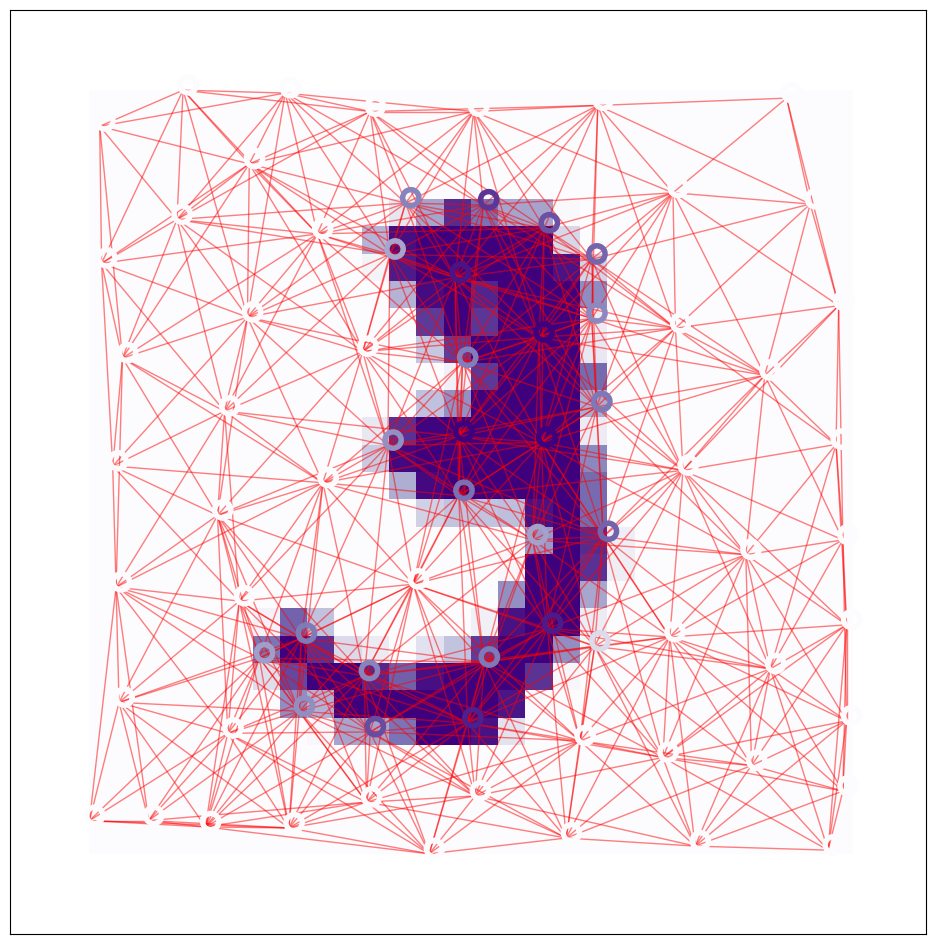

In [57]:
idx = 10
visualize_sample(idx, train_set, train_set_regular)

Digit: 3


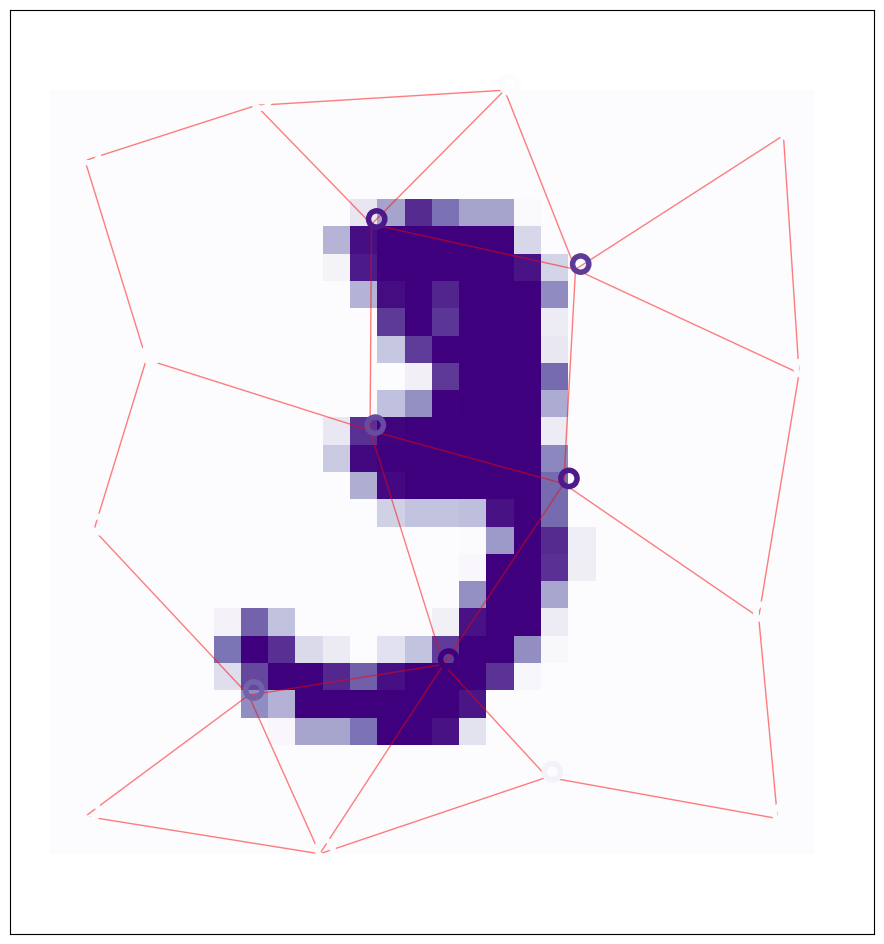

In [63]:
visualize_sample(idx, clustered_train_set, train_set_regular)

In [71]:
# get the transformed sample
transformed_sample = clustered_train_set[idx]
transformed_sample

Data(x=[18, 1], y=[1], pos=[18, 2], edge_index=[2, 50])

In [73]:
original_data = train_set[idx]
original_data

Data(x=[75, 1], edge_index=[2, 1138], y=[1], pos=[75, 2])

In [65]:
# Check how much does it take to transform 1000 datapoints
import time
start = time.time()
for i in range(1000):
    transformed_sample = clustered_train_set[i]
end = time.time()
print(end - start)

32.515960454940796


In [68]:
from utils.transforms import Graph_to_Subgraph
transforms = []
subgraph_dict = {'mode': 'transformer_8'}
if subgraph_dict is not None:
    subgraph_mode = subgraph_dict.get("mode", None)
    transforms.append(Graph_to_Subgraph(mode=subgraph_mode))
    transforms = Compose(transforms)
train_val_set = tg.datasets.MNISTSuperpixels(root='./datasets', transform=transforms, train=True)
# Check how much does it take to transform 1000 datapoints
import time
start = time.time()
for i in range(1000):
    transformed_sample = train_val_set[i]
end = time.time()
print(end - start)

2.4778850078582764


In [69]:
len(train_set)

60000